# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import \
    classification_report, roc_auc_score, roc_curve, auc

data = pd.read_csv('spam_or_not_spam.zip')
data.head(2)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0


In [95]:
# Расчет частоты для классов
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

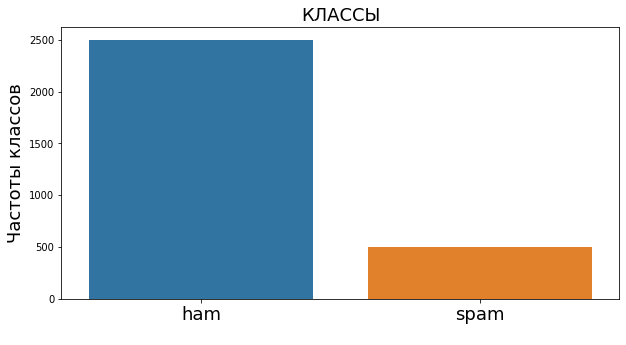

In [96]:
# Визуализация
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=data, x='label')
ax.set_title('КЛАССЫ', fontsize = 18)
ax.set_ylabel('Частоты классов', fontsize = 18)
ax.set_xlabel(' ')
ax.set_xticks(ticks=[0,1], labels=['ham', 'spam'], fontsize = 18)
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [97]:
from sklearn.feature_extraction.text import CountVectorizer

Замените все пустоты (пустые строки) в данных на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [98]:
data = data.replace ( r'^\s\*$' , np.nan , regex= True )
data.dropna(inplace=True)

Переводим данные в векторный вид:

In [99]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [100]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [101]:
X = X.toarray()
y = data['label']

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [103]:
y_test.mean()

0.164

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

Классы несбалансированы, поэтому выбираем ComplementNB. Это адаптация стандартного полиномиального наивного байесовского алгоритма, которая особенно подходит для несбалансированных наборов данных.

In [104]:
nbc = ComplementNB(alpha=0.01)
nbc.fit(X_train, y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [105]:
y_test_pred = nbc.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.997     0.997     0.997       627
           1      0.984     0.984     0.984       123

    accuracy                          0.995       750
   macro avg      0.990     0.990     0.990       750
weighted avg      0.995     0.995     0.995       750



Нарисуйте ROC-кривую:

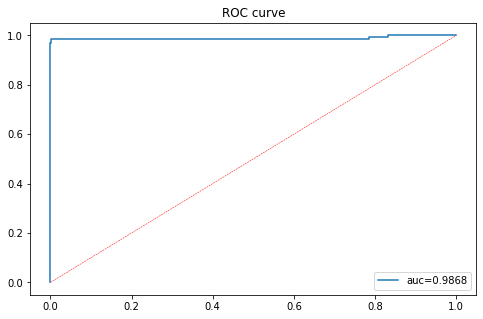

In [106]:
y_pred_proba = nbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr,tpr,label="auc="+str(round(auc,4)))
ax.plot([0, 1], [0, 1],'r--', lw=0.5)
plt.title('ROC curve')
plt.legend()
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

Кросс-валидация, среднее значение метрики по 5 фолдам
alpha = 0.001; f1-score = 0.955
alpha = 0.010; f1-score = 0.956
alpha = 0.100; f1-score = 0.970
alpha = 1.000; f1-score = 0.962
alpha = 3.000; f1-score = 0.891
alpha = 5.000; f1-score = 0.759


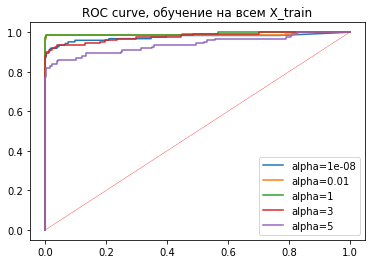

In [107]:
print('Кросс-валидация, среднее значение метрики по 5 фолдам')
a = [0.001, 0.01, 0.1, 1, 3, 5]
for alpha in a:
    nbc = ComplementNB(alpha=alpha)
    f1_score = cross_val_score(nbc, X_train, y_train, cv=5, scoring='f1').mean()
    
    print('alpha = {:.3f}; f1-score = {:.3f}'.format(
        alpha, f1_score ))
    
    #визуализация влияния параметра alfa    
for alpha in [1e-8, 0.01, 1, 3, 5]:
    nbc = ComplementNB(alpha=alpha)    
    nbc.fit(X_train, y_train)
    y_pred_proba = nbc.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr,tpr,label="alpha="+str(alpha))
    plt.plot([0, 1], [0, 1],'r--', lw=0.1)
    plt.title('ROC curve, обучение на всем X_train')
    plt.legend()

## Вывод  
Качество классификации зависит от значения параметра alpha. Можно найти оптимальное значение.